<a href="https://colab.research.google.com/github/spcnz/image-captioning/blob/main/image_captioning_VGG_30k.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import pandas as pd
import numpy as np
import tensorflow as tf
import warnings
import matplotlib.pyplot as plt

import seaborn as sns
from textwrap import wrap

plt.rcParams['font.size'] = 12
sns.set_style("dark")
warnings.filterwarnings('ignore')

!nvidia-smi

Fri Apr 14 16:17:52 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   31C    P0    48W / 400W |      0MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Download dataset from kaggle


In [2]:
!pip install -U -q kaggle
!mkdir -p ~/.kaggle
!echo '{"username":"milenalaketic","key":"46a3339b945bfda86a00d9e13708299e"}' > ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d hsankesara/flickr-image-dataset
! unzip /content/flickr-image-dataset.zip -d flickr30k

Streaming output truncated to the last 5000 lines.
  inflating: flickr30k/flickr30k_images/flickr30k_images/flickr30k_images/5354911151.jpg  
  inflating: flickr30k/flickr30k_images/flickr30k_images/flickr30k_images/535529555.jpg  
  inflating: flickr30k/flickr30k_images/flickr30k_images/flickr30k_images/5356236664.jpg  
  inflating: flickr30k/flickr30k_images/flickr30k_images/flickr30k_images/5356318668.jpg  
  inflating: flickr30k/flickr30k_images/flickr30k_images/flickr30k_images/535830521.jpg  
  inflating: flickr30k/flickr30k_images/flickr30k_images/flickr30k_images/5359437945.jpg  
  inflating: flickr30k/flickr30k_images/flickr30k_images/flickr30k_images/5361355399.jpg  
  inflating: flickr30k/flickr30k_images/flickr30k_images/flickr30k_images/53614287.jpg  
  inflating: flickr30k/flickr30k_images/flickr30k_images/flickr30k_images/536147209.jpg  
  inflating: flickr30k/flickr30k_images/flickr30k_images/flickr30k_images/5361551308.jpg  
  inflating: flickr30k/flickr30k_images/flic

# Display data

In [4]:
image_path = './flickr30k/flickr30k_images/flickr30k_images/flickr30k_images/'
data = pd.read_csv("./flickr30k/flickr30k_images/flickr30k_images/results.csv", delimiter='|')

data.rename(columns={'image_name': 'image', ' comment': 'caption'}, inplace=True)
data.head()

image  comment_number  \
0  1000092795.jpg               0   
1  1000092795.jpg               1   
2  1000092795.jpg               2   
3  1000092795.jpg               3   
4  1000092795.jpg               4   

                                             caption  
0   Two young guys with shaggy hair look at their...  
1   Two young , White males are outside near many...  
2   Two men in green shirts are standing in a yard .  
3       A man in a blue shirt standing in a garden .  
4            Two friends enjoy time spent together .

In [4]:
# data = data.sample(15)

In [5]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

def readImage(path, img_size=224):
    img = load_img(path,color_mode='rgb',target_size=(img_size,img_size))
    img = img_to_array(img)
    img = img / 255.
    
    return img


def display_images(temp_df, image_num):
    temp_df = temp_df.reset_index(drop=True)
    plt.figure(figsize = (20 , 20))
    n = 0
    for i in range(image_num):
        n+=1
        plt.subplot(5 , 5, n)
        plt.subplots_adjust(hspace = 0.7, wspace = 0.3)
        image = readImage(f"./flickr30k/flickr30k_images/flickr30k_images/flickr30k_images/{temp_df.image[i]}")
        plt.imshow(image)
        title = "\n".join(wrap(temp_df.caption[i], 20))
        plt.title(title)
        plt.axis("off")

plt.rcParams['font.size'] = 10

def display_results(temp_df, image_num):
    temp_df = temp_df.reset_index(drop=True)
    plt.figure(figsize = (20 , 20))
    n = 0
    for i in range(image_num):
        n+=1
        plt.subplot(5 , 5, n)
        plt.subplots_adjust(hspace = 0.7, wspace = 0.3)
        image = readImage(f"./flickr30k/flickr30k_images/flickr30k_images/flickr30k_images/{temp_df.image[i]}")
        plt.imshow(image)
        caption = "\n".join(wrap(temp_df.caption[i][8:-6], 30))
        predicted = "\n".join(wrap(temp_df.generated_caption[i][8:-6], 30))
        bleu = '\nBLEU:{:.4f}'.format(temp_df.bleu[i])

        plt.text(0, 0 , caption + "\n\nPredicted: " + predicted + "\n" + bleu + "\n")
        plt.axis("off")


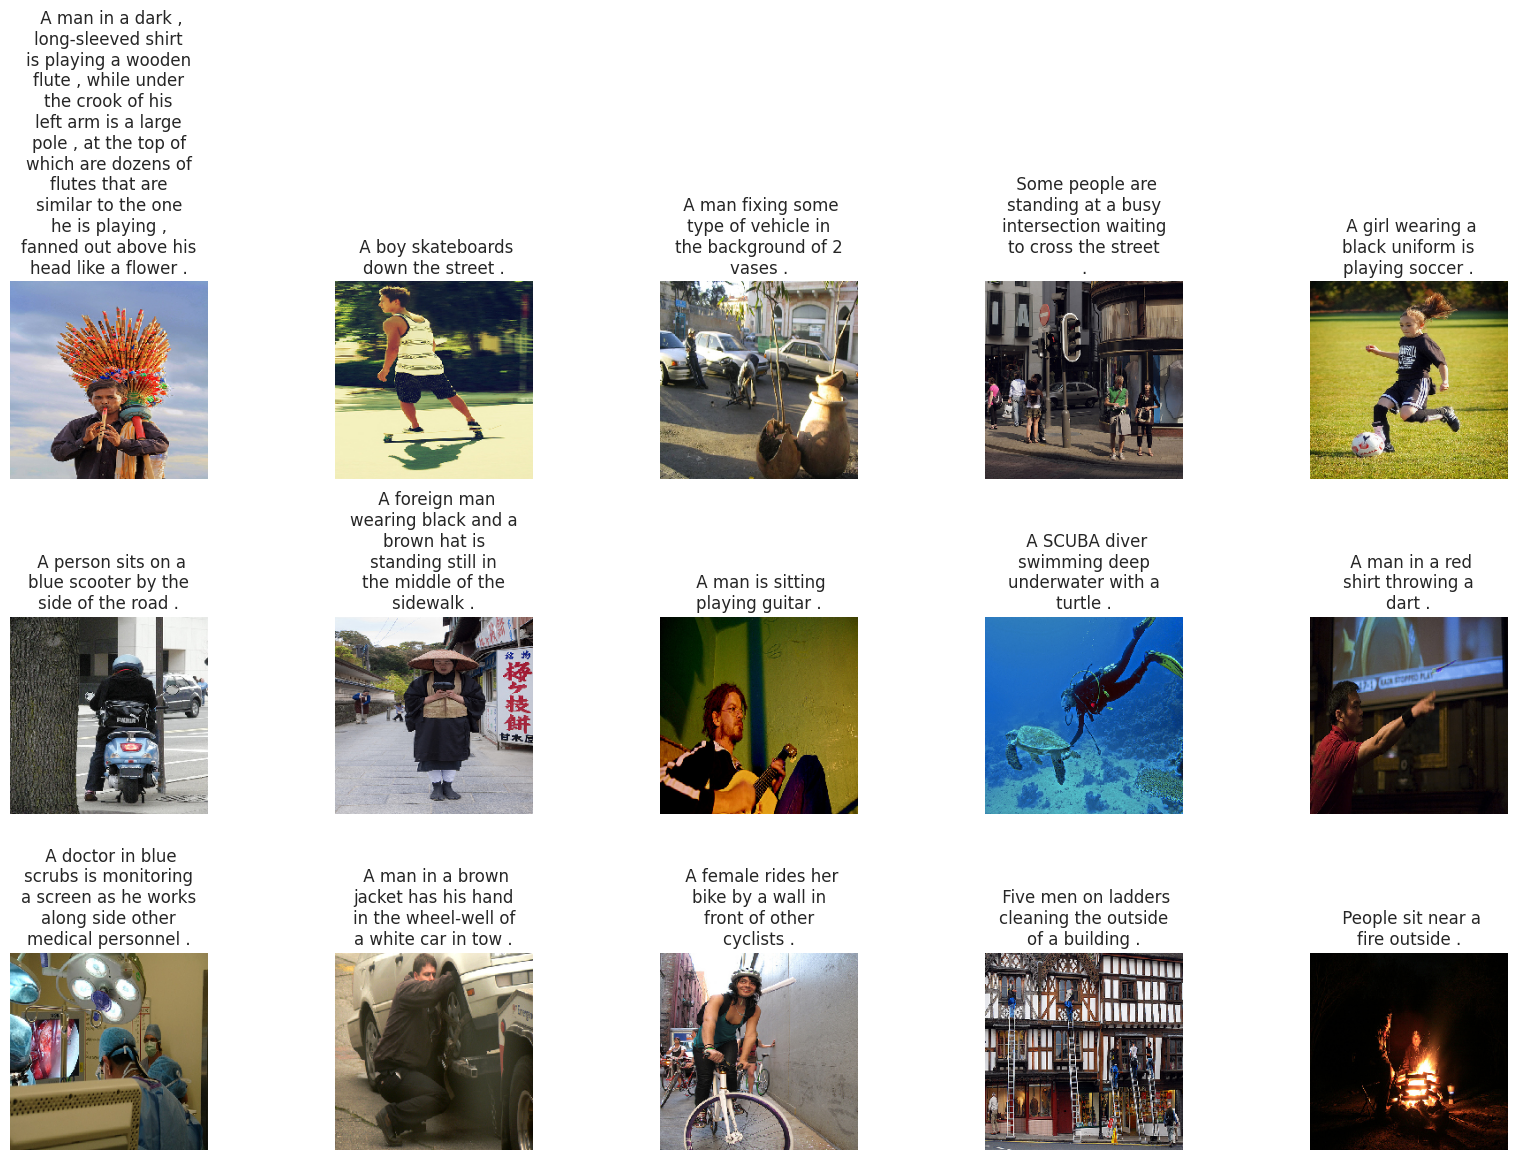

In [9]:
display_images(data.sample(15), 15)


# Preprocessing

## Captions preparation

In [6]:
import re 

def text_preprocessing(data):
    data['caption'] = exclude_special_characters(data['caption'])
    data['caption'] = to_lowercase(data['caption'])
    data['caption'] = remove_extra_whitespaces(data['caption'])
    data['caption'] = remove_single_characters(data['caption'])
    data['caption'] = add_start_end_tokens(data['caption'])
    return data

def to_lowercase(captions):
  return captions.apply(lambda x: x.lower())

def exclude_special_characters(captions):
  return captions.apply(lambda x: re.sub(r"[^A-Za-z ]", "", x))

def remove_extra_whitespaces(captions):
  return captions.apply(lambda x: re.sub("\s{2,}", " ", x.strip()))

def remove_single_characters(captions):
  return captions.apply(lambda x: " ".join([word for word in x.split() if len(word)>1]))

def add_start_end_tokens(captions):
  return "startseq " + captions + " endseq"


In [7]:
data = data.dropna()

captions = text_preprocessing(data)['caption'].tolist()

captions[:10]


['startseq two young guys with shaggy hair look at their hands while hanging out in the yard endseq',
 'startseq two young white males are outside near many bushes endseq',
 'startseq two men in green shirts are standing in yard endseq',
 'startseq man in blue shirt standing in garden endseq',
 'startseq two friends enjoy time spent together endseq',
 'startseq several men in hard hats are operating giant pulley system endseq',
 'startseq workers look down from up above on piece of equipment endseq',
 'startseq two men working on machine wearing hard hats endseq',
 'startseq four men on top of tall structure endseq',
 'startseq three men on large rig endseq']

## Tokenization
- Reprsent each word as one hot encoding vector
- Calculate vocabulary size
- Calculate maximum sentence length

In [8]:
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()
tokenizer.fit_on_texts(captions)
vocab_size = len(tokenizer.word_index) + 1

max_length = max(len(caption.split()) for caption in captions)
  

print(f'{captions[1]} -> {tokenizer.texts_to_sequences([captions[1]])[0]}')
print(f'{captions[2]} -> {tokenizer.texts_to_sequences([captions[2]])[0]}')

startseq two young white males are outside near many bushes endseq -> [1, 12, 19, 20, 703, 13, 54, 79, 192, 1415, 2]
startseq two men in green shirts are standing in yard endseq -> [1, 12, 29, 3, 46, 252, 13, 31, 3, 485, 2]


## Define train and test datasets

*   85% of all data is used for training
* 15% of training dataset is used for validation



In [9]:
def get_unique_images(data):
  return data['image'].unique().tolist()

def train_test_split(images, train_size):
  split_idx = round(train_size * len(images))

  return images[:split_idx], images[split_idx:]

def get_image_and_captions(data, images):
  return data[data['image'].isin(images)]

images = get_unique_images(data)
train_images, test_images = train_test_split(images, 0.85) 
train_images, val_images = train_test_split(train_images, 0.85)


train = get_image_and_captions(data, train_images)
validation = get_image_and_captions(data, val_images)
test = get_image_and_captions(data, test_images)

# Encoder
- use VGG19 as encoder part
- remove last 2 layers of VGG19 trained on `imagenet` dataset

In [10]:
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.models import Model


cnn = VGG19(weights='imagenet')
encoder = Model(inputs=cnn.input, outputs=cnn.layers[-2].output)

## Extract features from images 

- normalization and color channel reordering


In [15]:
from tqdm import tqdm
import os
from tensorflow.keras.applications.vgg19 import preprocess_input

INPUT_SIZE = 224
FEATURE_SIZE = 4096
features = {}
for image_name in tqdm(data['image'].unique().tolist()):
    image = load_img(
        os.path.join(image_path, image_name),
        target_size=(INPUT_SIZE, INPUT_SIZE)
        )
    image = img_to_array(image)
    image = np.expand_dims(image, axis=0)
    image = preprocess_input(image)
    feature = encoder.predict(image, verbose=0)
    features[image_name] = feature

100%|██████████| 31783/31783 [33:09<00:00, 15.97it/s]


In [11]:
import pickle

# with open('features.pkl', 'wb') as f: 
#     pickle.dump(features, f) 

with open('features.pkl', 'rb') as f:
    features = pickle.load(f)

## Define Data generator
 - Create batches of data during training process
  - Each batch is in form of (X = input_data, y = target_data)
 - The inputs are image embeddings and their corresonding caption text embeddings
 - Add padding to caption embeddings

In [12]:
from tensorflow.keras.utils import Sequence, to_categorical, pad_sequences

class DataGenerator(Sequence):
    
    def __init__(self, df, X_col, y_col, batch_size, tokenizer, 
                 vocab_size, max_length, features, shuffle=True):
    
        self.df = df.copy()
        self.X_col = X_col
        self.y_col = y_col
        self.batch_size = batch_size
        self.tokenizer = tokenizer
        self.vocab_size = vocab_size
        self.max_length = max_length
        self.features = features
        self.shuffle = shuffle
        self.n = len(self.df)
        
    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)
    
    def __len__(self):
        return self.n // self.batch_size
    
    def __getitem__(self, index):
    
        batch = self.df.iloc[index * self.batch_size:(index + 1) * self.batch_size,:]
        X1, X2, y = self.__get_data(batch)    

        return (X1, X2), y
    
    def __get_data(self, batch):
        
        X1, X2, y = list(), list(), list()
        
        images = batch[self.X_col].tolist()
           
        for image in images:
            feature = self.features[image][0]
            
            captions = batch.loc[batch[self.X_col]==image, self.y_col].tolist()
            for caption in captions:
                seq = self.tokenizer.texts_to_sequences([caption])[0]

                for i in range(1,len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=self.max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=self.vocab_size)[0]
                    X1.append(feature)
                    X2.append(in_seq)
                    y.append(out_seq)
            
        X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                
        return X1, X2, y

In [13]:
train_generator = DataGenerator(
    df=train,
    X_col='image',
    y_col='caption',
    batch_size=128,
    tokenizer=tokenizer,
    vocab_size=vocab_size,
    max_length=max_length,
    features=features
    )

validation_generator = DataGenerator(
    df=validation,
    X_col='image',
    y_col='caption',
    batch_size=128,
    tokenizer=tokenizer,
    vocab_size=vocab_size,
    max_length=max_length,
    features=features
    )

# Model

## Architecture

In [14]:
from tensorflow.keras.layers import Input, Dropout, Dense, Reshape, Embedding, concatenate, LSTM, add

FEATURE_SIZE = features[images[0]].shape[1]

image_feature_input = Input(shape=(FEATURE_SIZE,))
caption_embedding_input = Input(shape=(max_length,))

img_features = Dense(256, activation='relu')(image_feature_input)
img_features_reshaped = Reshape((1, 256), input_shape=(256,))(img_features)


sentence_features = Embedding(vocab_size, 256, mask_zero=False)(caption_embedding_input)
merged = concatenate([img_features_reshaped, sentence_features], axis=1)
sentence_features = LSTM(256)(merged)

x = Dropout(0.5)(sentence_features)
x = add([x, img_features])
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(vocab_size, activation='softmax')(x)

caption_model = Model(inputs=[image_feature_input, caption_embedding_input], outputs=output)
caption_model.compile(loss='categorical_crossentropy',optimizer='adam')

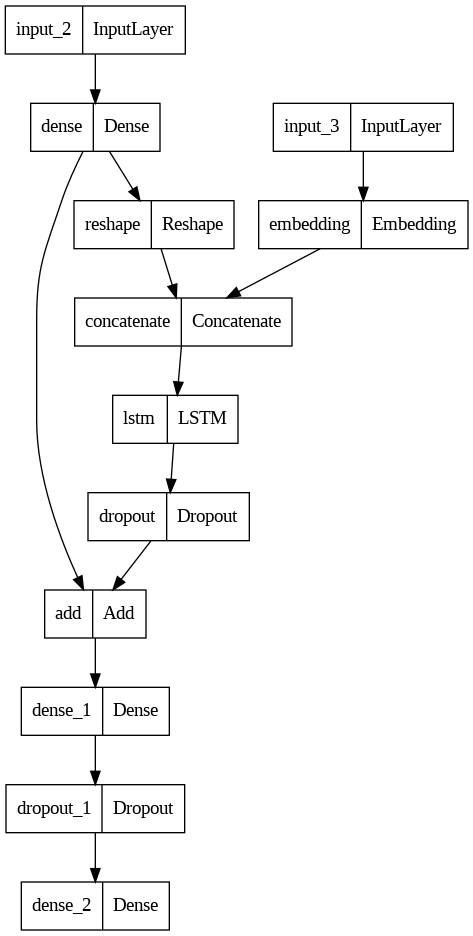

In [15]:
from tensorflow.keras.utils import plot_model

plot_model(caption_model)

In [16]:
caption_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 4096)]       0           []                               
                                                                                                  
 dense (Dense)                  (None, 256)          1048832     ['input_2[0][0]']                
                                                                                                  
 input_3 (InputLayer)           [(None, 74)]         0           []                               
                                                                                                  
 reshape (Reshape)              (None, 1, 256)       0           ['dense[0][0]']                  
                                                                                            

## Training

In [17]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

model_name = 'model_vgg19.h5'

checkpoint = ModelCheckpoint(
    model_name,
    monitor='val_loss',
    mode="min",
    save_best_only=True,
    verbose=1)

earlystopping = EarlyStopping(
    monitor='val_loss',
    min_delta = 0, 
    patience = 5, 
    verbose = 1, 
    restore_best_weights=True)

learning_rate_reduction = ReduceLROnPlateau(
    monitor='loss', 
    patience=3, 
    verbose=1, 
    factor=0.2, 
    min_lr=0.00000001)

In [18]:
history = caption_model.fit(
    train_generator,
    epochs=20,
    validation_data=validation_generator,
    callbacks=[checkpoint, earlystopping, learning_rate_reduction]
    )

Epoch 1/20
897/897 [==============================] - ETA: 0s - loss: 5.0452
Epoch 1: val_loss improved from inf to 4.32816, saving model to model_vgg19.h5
897/897 [==============================] - 959s 1s/step - loss: 5.0452 - val_loss: 4.3282 - lr: 0.0010
Epoch 2/20
897/897 [==============================] - ETA: 0s - loss: 4.2594
Epoch 2: val_loss improved from 4.32816 to 4.09625, saving model to model_vgg19.h5
897/897 [==============================] - 232s 259ms/step - loss: 4.2594 - val_loss: 4.0963 - lr: 0.0010
Epoch 3/20
897/897 [==============================] - ETA: 0s - loss: 4.0624
Epoch 3: val_loss improved from 4.09625 to 4.00679, saving model to model_vgg19.h5
897/897 [==============================] - 228s 254ms/step - loss: 4.0624 - val_loss: 4.0068 - lr: 0.0010
Epoch 4/20
897/897 [==============================] - ETA: 0s - loss: 3.9428
Epoch 4: val_loss improved from 4.00679 to 3.96150, saving model to model_vgg19.h5
897/897 [==============================] - 226s 2

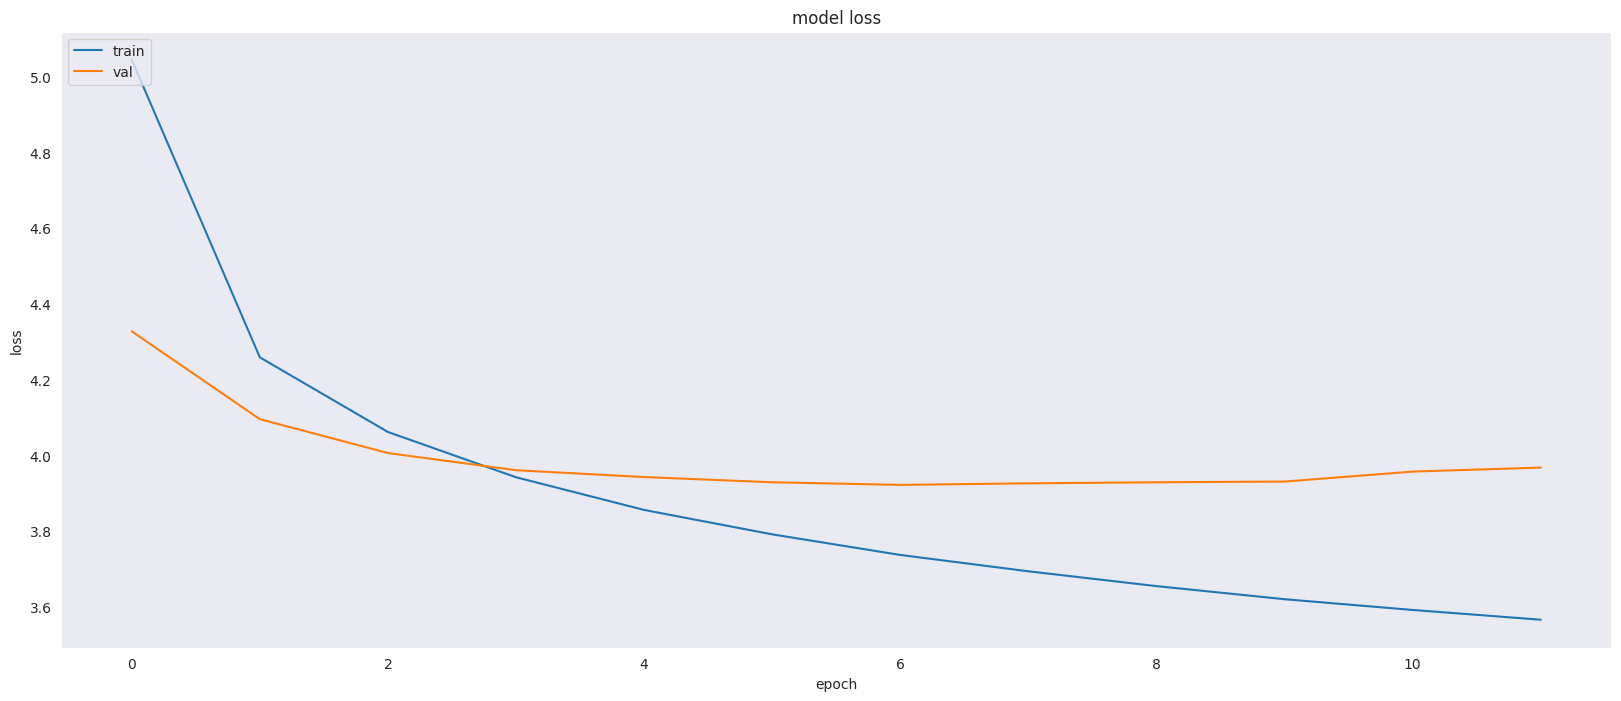

In [19]:
plt.figure(figsize=(20,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


# Inference
- Pass embedding of `startseq` and image feature to model 
- Generate words until `endseq` is generated

In [20]:
def idx_to_word(integer, tokenizer):
    
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [21]:
def predict_caption(model, image, tokenizer, max_length, features):
    
    feature = features[image]
    in_text = "startseq"
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], max_length)

        y_pred = model.predict([feature,sequence])
        y_pred = np.argmax(y_pred)
        
        word = idx_to_word(y_pred, tokenizer)
        
        if word is None:
            break
            
        in_text+= " " + word
        
        if word == 'endseq':
            break
            
    return in_text 

In [22]:
test = test.sample(15)
temp_df = pd.DataFrame()

for index,record in test.iterrows():
  temp_df = temp_df.append(test.loc[test['image'] == record["image"]])



temp_df = temp_df.reset_index(drop=True)
test = temp_df

In [25]:
import os

for index,record in test.iterrows():

    img = load_img(os.path.join(image_path,record['image']),target_size=(224,224))
    img = img_to_array(img)
    img = img/255.
    
    caption = predict_caption(caption_model, record['image'], tokenizer, max_length, features)
    test.loc[index,'generated_caption'] = caption
     

1/1 [==============================] - 0s 22ms/step


# Calculate BLEU score

In [26]:

import nltk
import nltk.translate.bleu_score as bleu
from nltk.translate.bleu_score import SmoothingFunction

for index,record in test.iterrows():
  image = record['image']
  captions =  test.loc[test['image'] == image, 'caption']\
              .apply(lambda caption : caption.split()[1:-1])\
              .to_list()

  bleu_score = bleu.sentence_bleu(
      captions, 
      record['generated_caption'].split()[1:-1],  
      smoothing_function=SmoothingFunction().method1) * 100
  test.loc[index,'bleu'] = bleu_score



In [27]:
print(test['bleu'].mean())
test = test.sort_values('bleu', ascending=False)

4.134316274781225


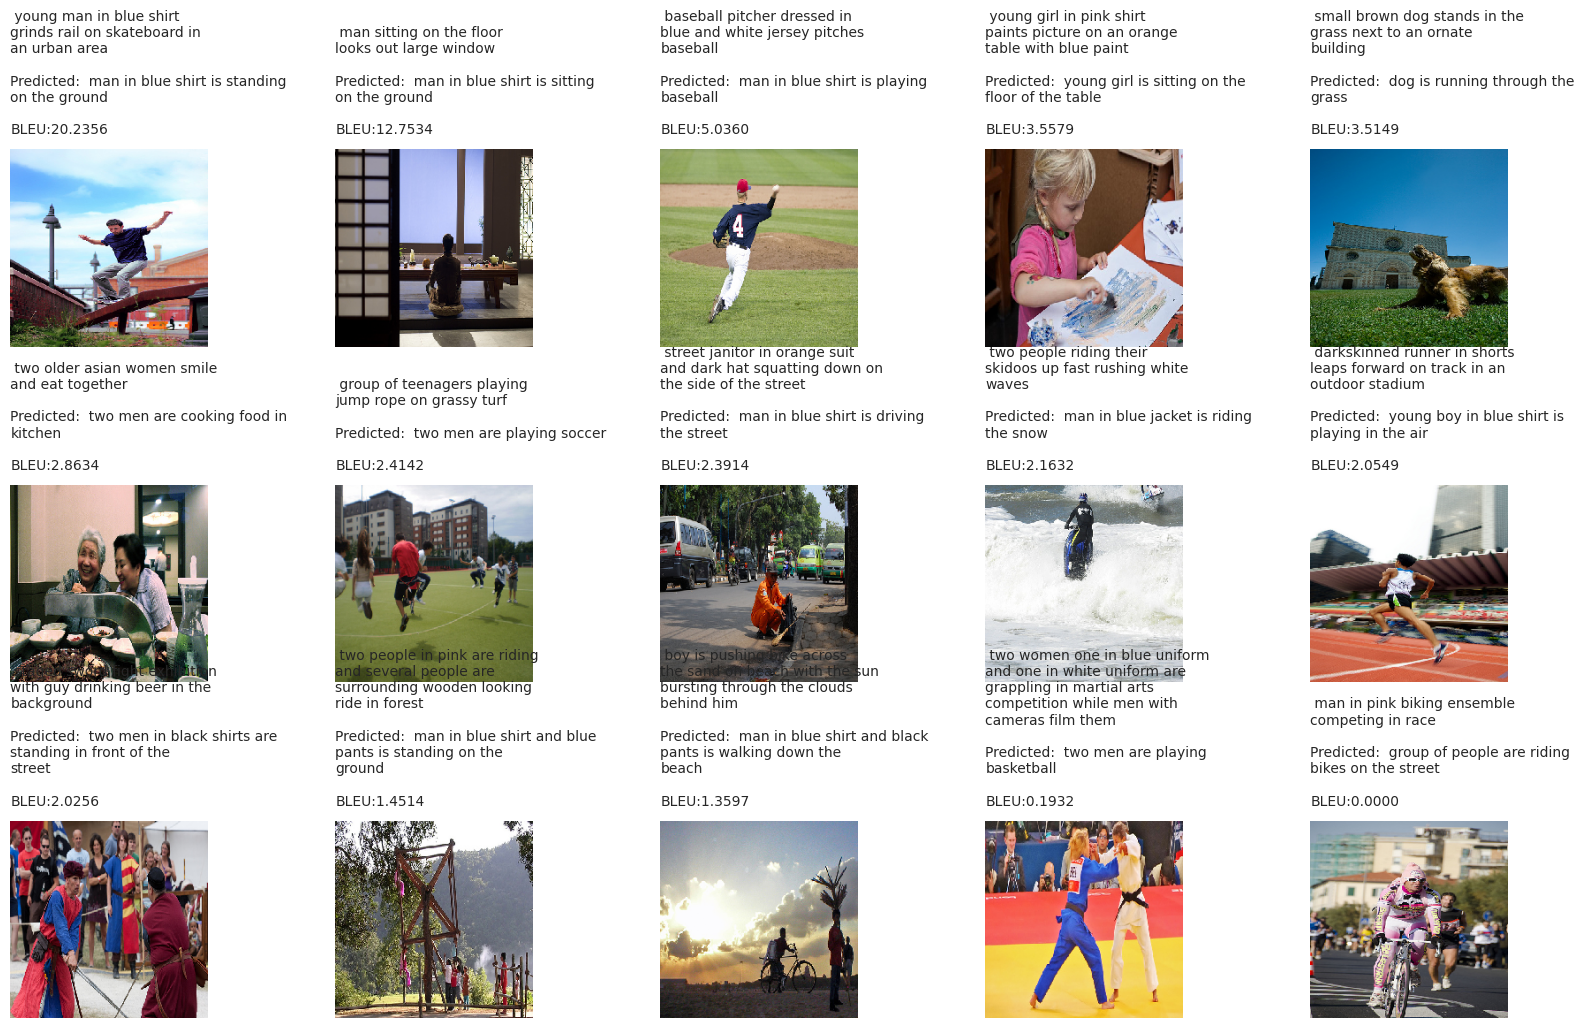

In [28]:
display_results(test, test.shape[0])
